In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sentence_transformers
from sklearn.metrics import silhouette_score
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))
from db.database import Database
from util.pandas import get_dataframes

In [2]:
db = Database()
bp_df, topics_df, posts_df = get_dataframes(db)
bp_df.head()

blueprint_code  \
0  blueprint:\n  name: Nag prompt blueprint\n  de...   
1  blueprint:\n  name: Inovelli \n  description: ...   
2  blueprint:\n  name: deCONZ - IKEA five button ...   
3  blueprint:\n  name: Heat for certain time\n  d...   
4  blueprint:\n  name: Light Allowance\n  descrip...   

                                       blueprint_url  post_id  \
0  https://community.home-assistant.io//t/nag-pro...  1220860   
1  https://community.home-assistant.io//t/inovell...  1220678   
2  https://community.home-assistant.io//t/deconz-...  1223455   
3  https://community.home-assistant.io//t/set-hea...  1223628   
4  https://community.home-assistant.io//t/light-a...  1224871   

                                         description  \
0                Nag a mobile device to do something   
1  Use this blueprint to create automations based...   
2   Control anything using IKEA five button remote\n   
3        Turn on heating for a given amount of time.   
4           Turns a light off after an allotted time   

                                      topic_keywords  \
0  {"nag": 0.66021433671546, "prompt": 0.23634566...   
1  {"inovelli": 0.49695533075954657, "lzw36": 0.4...   
2  {"button": 0.47028047688169866, "five": 0.3549...   
3  {"heat": 0.3484675281776271, "heating": 0.3360...   
4  {"allotted": 0.6330710810698282, "allowance": ...   

                                      keywords_tfidf  \
0  {"nag": 0.8500419399246807, "prompt": 0.303868...   
1  {"lzw36": 0.44023949481589464, "inovelli": 0.4...   
2  {"five": 0.5604759426620674, "ikea": 0.4331904...   
3  {"heat": 0.44290156715634094, "heating": 0.430...   
4  {"allotted": 0.6465282359948884, "allowance": ...   

                                      blueprint_hash  id  \
0  2f523787adf856fbddd08b2f7b32aa2490eb48a236bc68...   1   
1  ca6a74b04fac9cee0925adfe7cb03c8beb0354a816fa66...   2   
2  c5f67655e23dff66b1042d3b38e967d74dad01a4a3d589...   3   
3  00b1c4d2e847ed9451c8e8d1acfbbcd5e1740f9991226d...   4   
4  0dd0ec70d42f2e8a428ae7a2934852dbec0beb34cd03cc...   5   

                               name  \
0              Nag prompt blueprint   
1                          Inovelli   
2  deCONZ - IKEA five button remote   
3             Heat for certain time   
4                   Light Allowance   

                                  extracted_keywords  \
0                        {"input__input_boolean": 2}   
1                                                 {}   
2                               {"input__deconz": 1}   
3  {"input__input_datetime": 1, "input__climate": 2}   
4            {"input__light": 1, "output__light": 1}   

                                       keywords_yake  \
0  ["android notification", "nag prompt", "nag no...   
1            ["fan", "inovelli", "create", "dimmer"]   
2  ["button short", "button remote", "long press"...   
3  ["set heating", "heating temperature", "time",...   
4  ["light allowance", "light", "allowance", "all...   

                                         topic_title topic_id  \
0        Nag prompt Blueprint (Android Notification)   255041   
1                   Inovelli LZW36 Fan/Dimmer Scenes   254999   
2                   deCONZ - IKEA five button remote   255699   
3  Set heating temperature to a configurable valu...   255742   
4                                    Light Allowance   256045   

                                tags              created_at  \
0                                 [] 2020-12-14 01:40:32.358   
1                      ["blueprint"] 2020-12-13 22:32:38.158   
2  ["switch", "blueprint", "deconz"] 2020-12-15 12:18:15.898   
3                                 [] 2020-12-15 14:23:53.414   
4                                 [] 2020-12-16 04:23:36.519   

                                        post_content       processed_keywords  
0  <p>This blueprints creates configurable nag no...              ["boolean"]  
1  <p>This blueprint allows you to easily create ...                     null  
2  <p>This is

In [3]:
import json, re
def process_bp_keywords(kwd_dict: dict[str, int] | str) -> list[str] | None:
    if isinstance(kwd_dict, str):
        kwd_dict = json.loads(kwd_dict)
    
    kwd_list = list(kwd_dict.keys())
    if kwd_list.__len__() < 1:
        return None
    
    kwds = []
    
    for kwd in kwd_list:
        in_out = re.search(r"(input__|output__)(input_|output_)?", kwd)
        kwd = kwd.removeprefix(in_out.group()) if in_out else kwd
        in_out = in_out.group(1) if in_out else None
        kwds.append(in_out + kwd if in_out else kwd)
    return kwds

In [4]:
ignorable_tags = {"blueprint", "automation"}
bp_df["tags"] = bp_df["tags"].apply(lambda tags: [tag for tag in json.loads(tags) if tag not in ignorable_tags])
bp_df.head()

blueprint_code  \
0  blueprint:\n  name: Nag prompt blueprint\n  de...   
1  blueprint:\n  name: Inovelli \n  description: ...   
2  blueprint:\n  name: deCONZ - IKEA five button ...   
3  blueprint:\n  name: Heat for certain time\n  d...   
4  blueprint:\n  name: Light Allowance\n  descrip...   

                                       blueprint_url  post_id  \
0  https://community.home-assistant.io//t/nag-pro...  1220860   
1  https://community.home-assistant.io//t/inovell...  1220678   
2  https://community.home-assistant.io//t/deconz-...  1223455   
3  https://community.home-assistant.io//t/set-hea...  1223628   
4  https://community.home-assistant.io//t/light-a...  1224871   

                                         description  \
0                Nag a mobile device to do something   
1  Use this blueprint to create automations based...   
2   Control anything using IKEA five button remote\n   
3        Turn on heating for a given amount of time.   
4           Turns a light off after an allotted time   

                                      topic_keywords  \
0  {"nag": 0.66021433671546, "prompt": 0.23634566...   
1  {"inovelli": 0.49695533075954657, "lzw36": 0.4...   
2  {"button": 0.47028047688169866, "five": 0.3549...   
3  {"heat": 0.3484675281776271, "heating": 0.3360...   
4  {"allotted": 0.6330710810698282, "allowance": ...   

                                      keywords_tfidf  \
0  {"nag": 0.8500419399246807, "prompt": 0.303868...   
1  {"lzw36": 0.44023949481589464, "inovelli": 0.4...   
2  {"five": 0.5604759426620674, "ikea": 0.4331904...   
3  {"heat": 0.44290156715634094, "heating": 0.430...   
4  {"allotted": 0.6465282359948884, "allowance": ...   

                                      blueprint_hash  id  \
0  2f523787adf856fbddd08b2f7b32aa2490eb48a236bc68...   1   
1  ca6a74b04fac9cee0925adfe7cb03c8beb0354a816fa66...   2   
2  c5f67655e23dff66b1042d3b38e967d74dad01a4a3d589...   3   
3  00b1c4d2e847ed9451c8e8d1acfbbcd5e1740f9991226d...   4   
4  0dd0ec70d42f2e8a428ae7a2934852dbec0beb34cd03cc...   5   

                               name  \
0              Nag prompt blueprint   
1                          Inovelli   
2  deCONZ - IKEA five button remote   
3             Heat for certain time   
4                   Light Allowance   

                                  extracted_keywords  \
0                        {"input__input_boolean": 2}   
1                                                 {}   
2                               {"input__deconz": 1}   
3  {"input__input_datetime": 1, "input__climate": 2}   
4            {"input__light": 1, "output__light": 1}   

                                       keywords_yake  \
0  ["android notification", "nag prompt", "nag no...   
1            ["fan", "inovelli", "create", "dimmer"]   
2  ["button short", "button remote", "long press"...   
3  ["set heating", "heating temperature", "time",...   
4  ["light allowance", "light", "allowance", "all...   

                                         topic_title topic_id  \
0        Nag prompt Blueprint (Android Notification)   255041   
1                   Inovelli LZW36 Fan/Dimmer Scenes   254999   
2                   deCONZ - IKEA five button remote   255699   
3  Set heating temperature to a configurable valu...   255742   
4                                    Light Allowance   256045   

               tags              created_at  \
0                [] 2020-12-14 01:40:32.358   
1                [] 2020-12-13 22:32:38.158   
2  [switch, deconz] 2020-12-15 12:18:15.898   
3                [] 2020-12-15 14:23:53.414   
4                [] 2020-12-16 04:23:36.519   

                                        post_content       processed_keywords  
0  <p>This blueprints creates configurable nag no...              ["boolean"]  
1  <p>This blueprint allows you to easily create ...                     null  
2  <p>This is a mix of <a href="https://community...               ["deconz"]  
3  <p>This is a blueprint, that all

In [5]:
max_keywords = bp_df["extracted_keywords"].apply(lambda x: len(json.loads(x)) if isinstance(x, str) else 0).max() 
max_tags = bp_df["tags"].apply(lambda x: len(x) if isinstance(x, list) else 0).max()
max_yake = 4
max_features = max_keywords + max_tags + max_yake
max_keywords, max_tags, max_features

(13, 5, 22)

In [6]:
def extract_features(row, max_features=max_features):
    padding = "<PAD>"
    
    yake_features = json.loads(row["keywords_yake"])
    combined_features = list(yake_features)
    ext_kw = process_bp_keywords(row["extracted_keywords"])
    if ext_kw:
        combined_features.extend(ext_kw)
    
    kw_n = max_keywords - len(ext_kw) if ext_kw else max_keywords
    combined_features += [padding] * kw_n
    
    tags = row["tags"]
    tag_n = max_tags - len(tags)
    combined_features.extend(tags)
    combined_features += [padding] * tag_n

    return combined_features

In [7]:
bp_df["features"] = bp_df.apply(extract_features, axis=1)
bp_df.head()

blueprint_code  \
0  blueprint:\n  name: Nag prompt blueprint\n  de...   
1  blueprint:\n  name: Inovelli \n  description: ...   
2  blueprint:\n  name: deCONZ - IKEA five button ...   
3  blueprint:\n  name: Heat for certain time\n  d...   
4  blueprint:\n  name: Light Allowance\n  descrip...   

                                       blueprint_url  post_id  \
0  https://community.home-assistant.io//t/nag-pro...  1220860   
1  https://community.home-assistant.io//t/inovell...  1220678   
2  https://community.home-assistant.io//t/deconz-...  1223455   
3  https://community.home-assistant.io//t/set-hea...  1223628   
4  https://community.home-assistant.io//t/light-a...  1224871   

                                         description  \
0                Nag a mobile device to do something   
1  Use this blueprint to create automations based...   
2   Control anything using IKEA five button remote\n   
3        Turn on heating for a given amount of time.   
4           Turns a light off after an allotted time   

                                      topic_keywords  \
0  {"nag": 0.66021433671546, "prompt": 0.23634566...   
1  {"inovelli": 0.49695533075954657, "lzw36": 0.4...   
2  {"button": 0.47028047688169866, "five": 0.3549...   
3  {"heat": 0.3484675281776271, "heating": 0.3360...   
4  {"allotted": 0.6330710810698282, "allowance": ...   

                                      keywords_tfidf  \
0  {"nag": 0.8500419399246807, "prompt": 0.303868...   
1  {"lzw36": 0.44023949481589464, "inovelli": 0.4...   
2  {"five": 0.5604759426620674, "ikea": 0.4331904...   
3  {"heat": 0.44290156715634094, "heating": 0.430...   
4  {"allotted": 0.6465282359948884, "allowance": ...   

                                      blueprint_hash  id  \
0  2f523787adf856fbddd08b2f7b32aa2490eb48a236bc68...   1   
1  ca6a74b04fac9cee0925adfe7cb03c8beb0354a816fa66...   2   
2  c5f67655e23dff66b1042d3b38e967d74dad01a4a3d589...   3   
3  00b1c4d2e847ed9451c8e8d1acfbbcd5e1740f9991226d...   4   
4  0dd0ec70d42f2e8a428ae7a2934852dbec0beb34cd03cc...   5   

                               name  \
0              Nag prompt blueprint   
1                          Inovelli   
2  deCONZ - IKEA five button remote   
3             Heat for certain time   
4                   Light Allowance   

                                  extracted_keywords  \
0                        {"input__input_boolean": 2}   
1                                                 {}   
2                               {"input__deconz": 1}   
3  {"input__input_datetime": 1, "input__climate": 2}   
4            {"input__light": 1, "output__light": 1}   

                                       keywords_yake  \
0  ["android notification", "nag prompt", "nag no...   
1            ["fan", "inovelli", "create", "dimmer"]   
2  ["button short", "button remote", "long press"...   
3  ["set heating", "heating temperature", "time",...   
4  ["light allowance", "light", "allowance", "all...   

                                         topic_title topic_id  \
0        Nag prompt Blueprint (Android Notification)   255041   
1                   Inovelli LZW36 Fan/Dimmer Scenes   254999   
2                   deCONZ - IKEA five button remote   255699   
3  Set heating temperature to a configurable valu...   255742   
4                                    Light Allowance   256045   

               tags              created_at  \
0                [] 2020-12-14 01:40:32.358   
1                [] 2020-12-13 22:32:38.158   
2  [switch, deconz] 2020-12-15 12:18:15.898   
3                [] 2020-12-15 14:23:53.414   
4                [] 2020-12-16 04:23:36.519   

                                        post_content       processed_keywords  \
0  <p>This blueprints creates configurable nag no...              ["boolean"]   
1  <p>This blueprint allows you to easily create ...                     null   
2  <p>This is a mix of <a href="https://community...               ["deconz"]   
3  <p>This is a blueprint, that

In [8]:
bp_df.loc[2, "features"]

['button short',
 'button remote',
 'long press',
 'button',
 'input__deconz',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 'switch',
 'deconz',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [9]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Apply the updated function
bp_df["features"] = bp_df.apply(lambda row: extract_features(row, max_features=15), axis=1)

bp_df["features"] = bp_df["features"].apply(lambda x: " ".join(x))  # Combine list of strings into a single string
bp_df["embeddings"] = bp_df["features"].apply(lambda x: model.encode(x))

# Create a feature matrix
X = np.vstack(bp_df["embeddings"].values)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Silhouette score for k=2: 0.0614
Silhouette score for k=3: 0.0453
Silhouette score for k=4: 0.0612
Silhouette score for k=5: 0.0632
Silhouette score for k=6: 0.0661
Silhouette score for k=7: 0.0743
Silhouette score for k=8: 0.0733
Silhouette score for k=9: 0.0802
Silhouette score for k=10: 0.0852
Silhouette score for k=11: 0.0898
Silhouette score for k=12: 0.0905
Silhouette score for k=13: 0.0922
Silhouette score for k=14: 0.0966
Silhouette score for k=15: 0.0999
Silhouette score for k=16: 0.0987
Silhouette score for k=17: 0.0965
Silhouette score for k=18: 0.0907
Silhouette score for k=19: 0.0894
Silhouette score for k=20: 0.0916
Silhouette score for k=21: 0.0817
Silhouette score for k=22: 0.0875
Silhouette score for k=23: 0.0874
Silhouette score for k=24: 0.0885
Silhouette score for k=25: 0.0921
Silhouette score for k=26: 0.0917
Silhouette score for k=27: 0.0918
Silhouette score for k=28: 0.0932
Silhouette score for k=29: 0.0917
Silhouette score for k=30: 0.0946
Silhouette score for k

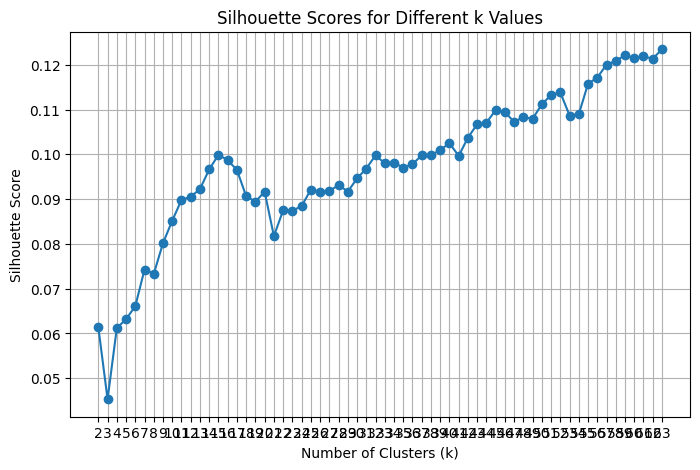

In [10]:
def plot_silhouette_scores(X, k_range):
    from sklearn.metrics import silhouette_score
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)
        print(f"Silhouette score for k={k}: {score:.4f}")
    
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, scores, marker='o')
    plt.title("Silhouette Scores for Different k Values")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.xticks(k_range)
    plt.grid()
    plt.show()
plot_silhouette_scores(X_scaled, range(2, 64))

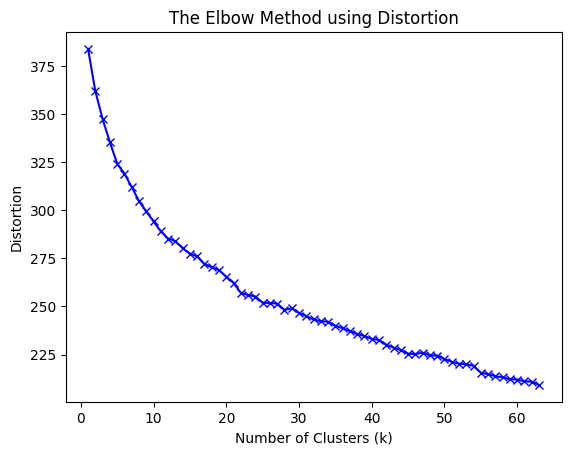

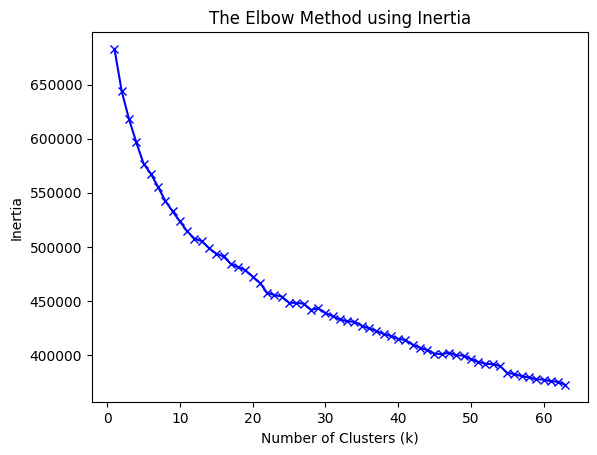

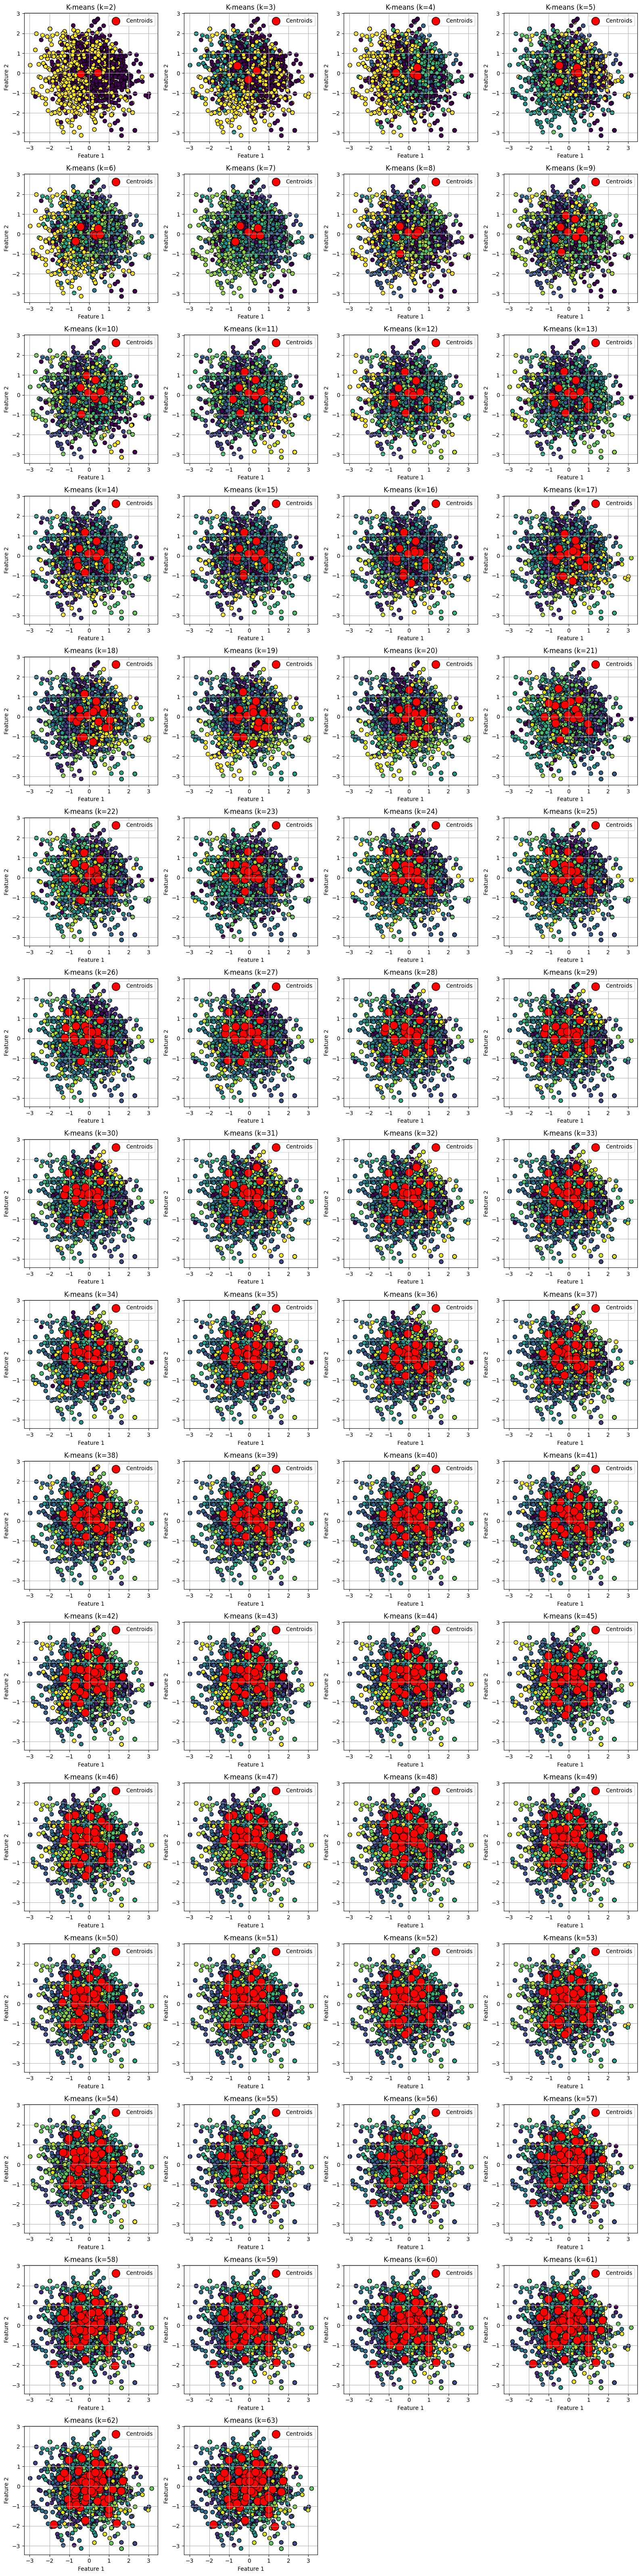

In [11]:
from scipy.spatial.distance import cdist
def plot_elbow(X, k_range):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, k_range.stop)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])
        inertias.append(kmeanModel.inertia_)
        mapping1[k] = distortions[-1]
        mapping2[k] = inertias[-1]

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()
    plt.close()
    
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()
    plt.close()
    
    n_plots = len(k_range)
    n_cols = 4
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()
    
    for idx, k in enumerate(k_range):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        y_kmeans = kmeans.fit_predict(X)

        axes[idx].scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', marker='o', edgecolor='k', s=50)
        axes[idx].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                    s=200, c='red', label='Centroids', edgecolor='k')
        axes[idx].set_title(f'K-means (k={k})')
        axes[idx].set_xlabel('Feature 1')
        axes[idx].set_ylabel('Feature 2')
        axes[idx].legend()
        axes[idx].grid()
    
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    plt.close()
plot_elbow(X_scaled, range(2, 64))

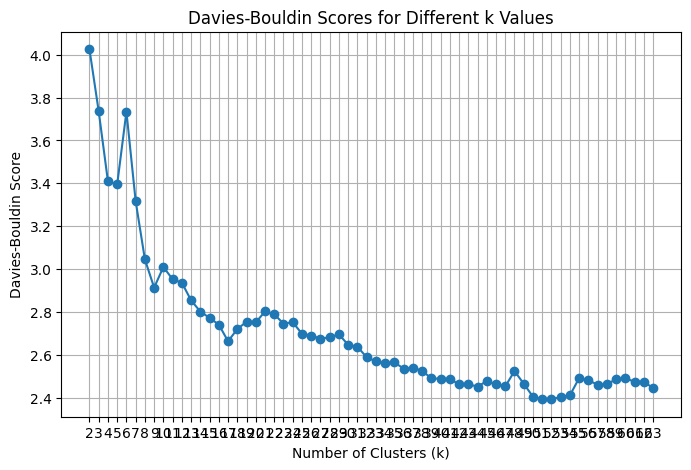

In [18]:
from sklearn.metrics import davies_bouldin_score
def davies_bouldin_scores(X, k_range):
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = davies_bouldin_score(X, labels)
        scores.append(score)
    
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, scores, marker='o')
    plt.title("Davies-Bouldin Scores for Different k Values")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Davies-Bouldin Score")
    plt.xticks(k_range)
    plt.grid()
    plt.show()
davies_bouldin_scores(X_scaled, range(2, 64))

Davies-Bouldin Score: 2.7888


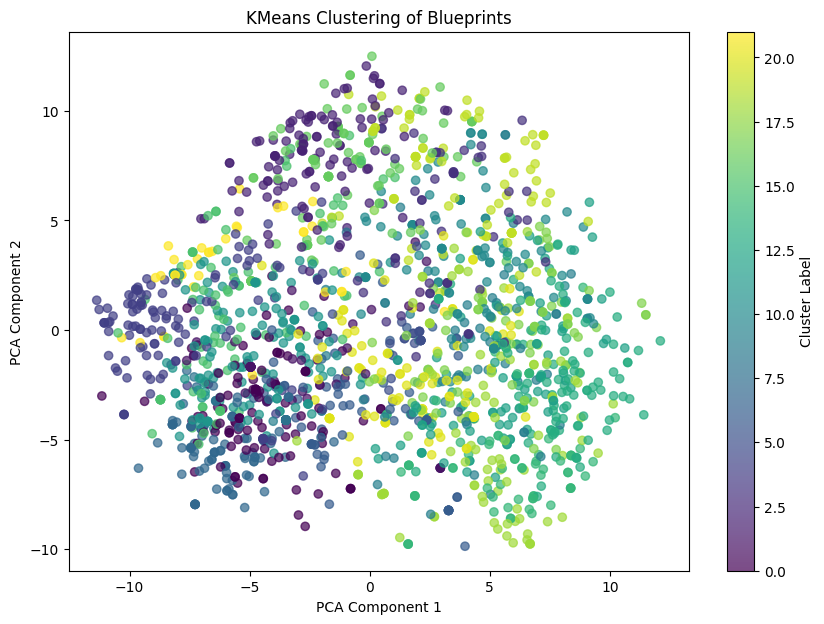

In [ ]:
kmeans = KMeans(n_clusters=22, random_state=42)
bp_df["cluster"] = kmeans.fit_predict(X_scaled)

def visualize_clusters(X, labels):
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.title("KMeans Clustering of Blueprints")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label="Cluster Label")
    plt.show()


visualize_clusters(X_scaled, bp_df["cluster"])  

In [13]:
from collections import Counter

def analyze_cluster_features(bp_df, cluster_id, top_n=10):
    """Analyze the most common features in a specific cluster"""
    cluster_data = bp_df[bp_df["cluster"] == cluster_id]
    
    all_features = []
    for features in cluster_data["features"]:
        feature_list = [f for f in features.split() if f != "<PAD>"]
        all_features.extend(feature_list)
    
    feature_counts = Counter(all_features)
    
    """ print(f"\nTop {top_n} features in Cluster {cluster_id}:")
    for feature, count in feature_counts.most_common(top_n):
        print(f"  {feature}: {count}") """
    
    return feature_counts.most_common(top_n)

for cluster_id in range(kmeans.n_clusters):
    analyze_cluster_features(bp_df, cluster_id, top_n=5)

In [14]:
from collections import Counter, defaultdict

cluster_features = defaultdict(list)
for idx, row in bp_df.iterrows():
    cluster_id = row["cluster"]
    feature_list = [f for f in row["features"].split() if f != "<PAD>"]
    cluster_features[cluster_id].extend(feature_list)

# Calculate feature frequencies per cluster
cluster_feature_counts = {}
for cluster_id, features in cluster_features.items():
    cluster_feature_counts[cluster_id] = Counter(features)

# Find features that are distinctive (appear heavily in some clusters but not others)
all_features = set()
for counts in cluster_feature_counts.values():
    all_features.update(counts.keys())

# Calculate variance in feature distribution across clusters
feature_variance = {}
for feature in all_features:
    counts = [cluster_feature_counts[c].get(feature, 0) for c in range(kmeans.n_clusters)]
    feature_variance[feature] = np.var(counts)

# Sort by variance (higher variance = more distinctive)
sorted_features = sorted(feature_variance.items(), key=lambda x: x[1], reverse=True)

print("\nTop 20 most distinctive features across clusters:")
for feature, variance in sorted_features[:20]:
    print(f"  {feature}: variance={variance:.2f}")
    cluster_presence = [(c, cluster_feature_counts[c].get(feature, 0)) 
                       for c in range(kmeans.n_clusters) 
                       if cluster_feature_counts[c].get(feature, 0) > 0]
    cluster_presence.sort(key=lambda x: x[1], reverse=True)
    print(f"    Most common in clusters: {cluster_presence[:3]}")


Top 20 most distinctive features across clusters:
  switch: variance=1920.81
    Most common in clusters: [(13, 168), (10, 153), (12, 39)]
  temperature: variance=1074.27
    Most common in clusters: [(4, 158), (21, 9), (16, 8)]
  input__binary_sensor: variance=653.04
    Most common in clusters: [(2, 94), (11, 85), (4, 27)]
  light: variance=621.50
    Most common in clusters: [(16, 94), (2, 79), (19, 42)]
  lights: variance=587.63
    Most common in clusters: [(2, 84), (16, 82), (19, 44)]
  notification: variance=568.88
    Most common in clusters: [(7, 111), (11, 38), (15, 10)]
  remote: variance=542.61
    Most common in clusters: [(17, 110), (9, 30), (14, 23)]
  button: variance=421.47
    Most common in clusters: [(17, 61), (20, 60), (14, 58)]
  zigbee2mqtt: variance=386.69
    Most common in clusters: [(18, 81), (13, 55), (9, 16)]
  zigbee: variance=351.23
    Most common in clusters: [(14, 67), (13, 56), (18, 42)]
  climate: variance=334.07
    Most common in clusters: [(4, 88

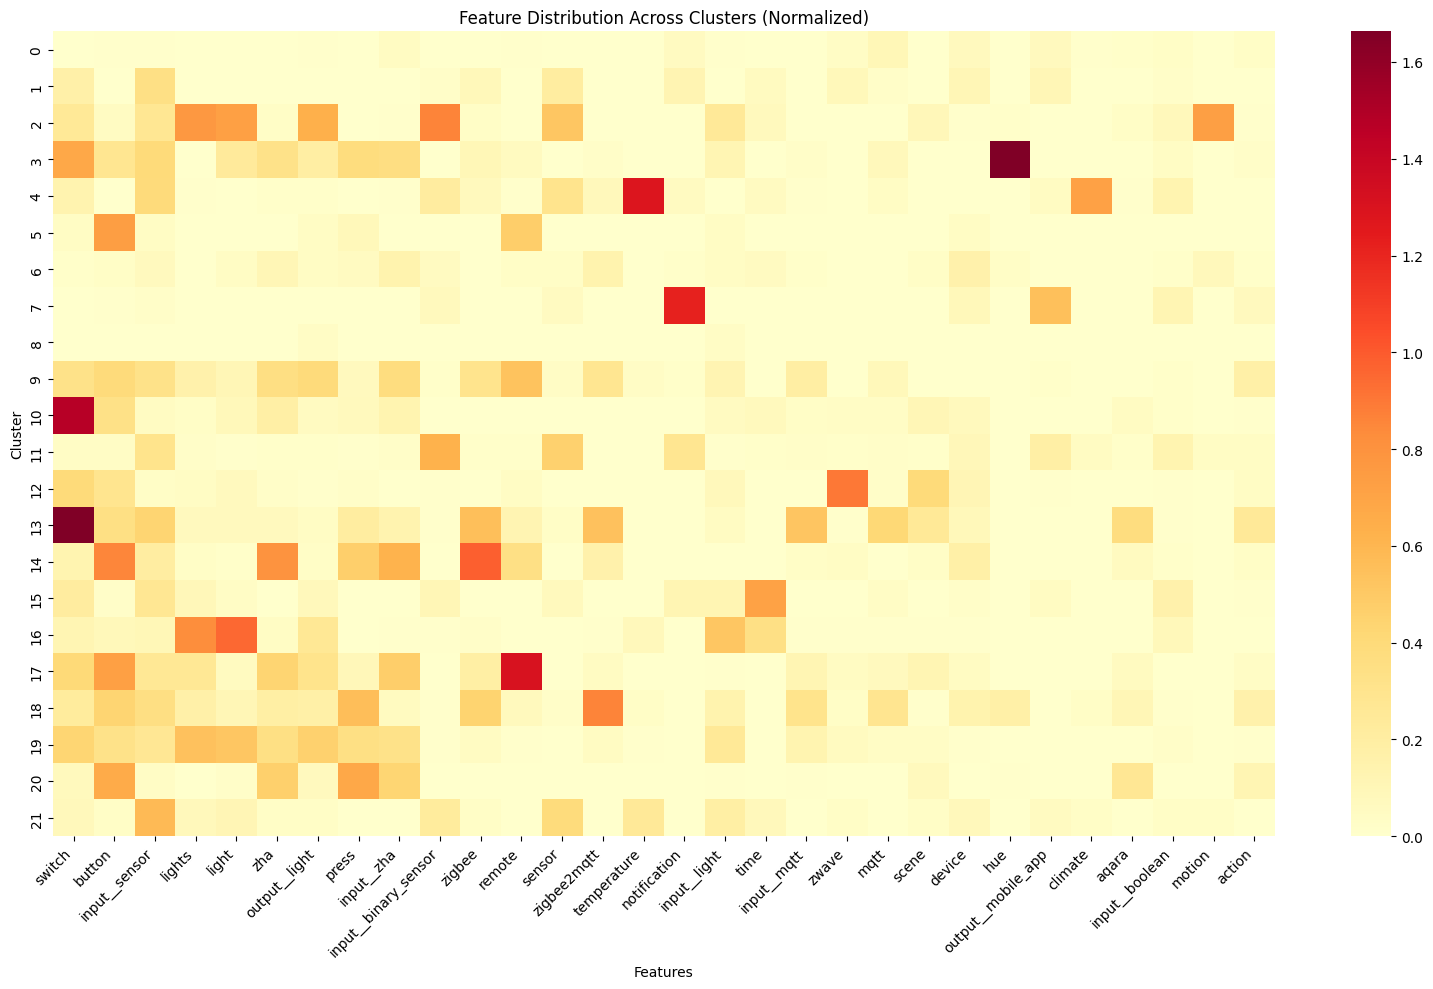

In [15]:
import seaborn as sns

# Get top features overall
all_feature_counts = Counter()
for features in bp_df["features"]:
    feature_list = [f for f in features.split() if f != "<PAD>"]
    all_feature_counts.update(feature_list)

top_features = [f for f, _ in all_feature_counts.most_common(30)]

# Create matrix: clusters x features
matrix = np.zeros((kmeans.n_clusters, len(top_features)))
for cluster_id in range(kmeans.n_clusters):
    cluster_counts = cluster_feature_counts[cluster_id]
    for i, feature in enumerate(top_features):
        matrix[cluster_id, i] = cluster_counts.get(feature, 0)

# Normalize by cluster size
cluster_sizes = bp_df["cluster"].value_counts().sort_index()
matrix = matrix / cluster_sizes.values[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(matrix, xticklabels=top_features, yticklabels=range(kmeans.n_clusters), 
            cmap='YlOrRd', annot=False)
plt.title("Feature Distribution Across Clusters (Normalized)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
def write_to_md(filename: str):    
    with open(filename, "w", encoding="utf-8") as f:
        for cluster_id in range(kmeans.n_clusters):
            f.write(f"<details>\n")
            features = analyze_cluster_features(bp_df, cluster_id, top_n=5)
            f.write(f"<summary> Cluster {cluster_id} </summary>\n\n")
            f.write(f"Top 5 features: \n")
            for feature, count in features:
                f.write(f"- {feature}: {count} \n")
            f.write("\n")
            bps = bp_df[bp_df["cluster"] == cluster_id]
            for idx, bp in bps.iterrows():
                post_url = topics_df[topics_df["post_id"] == bp["post_id"]]["post_url"].values[0]
                f.write(f"{bp['name']}, {post_url} \n\n")
            f.write(f"</details>\n\n")
write_to_md("clusters_22.md")